Goals
You are a data scientist at a large construction company. In order to submit more competitive bids for contracts, the head of analytics and data science would like you to work on forecasting core construction material costs. You have access to the pricing information (per unit, in dollars) for the company’s past purchases of plywood, sheetrock, steel beams, rebar, and glass contracts over the past ten years in csv format. 

Currently, the company is able to purchase futures contracts in a material for up to six months in advance. Thus, your manager is most interested in forecasting the price of each commodity up to six months into the future. In particular, your manager feels it would be really useful to understand when a commodity price is about to increase temporarily, in order to either buy the commodity early or wait until after the temporary increase. 

Solution:
I used seasonal ARIMA on the data for each material and the months in which the price of each commodity is about to increase are:
Steel: Nov-Dec - so either wait until next March to buy, or stock up in late October;
Rebar: Aug-Sept - best to stock up in June-July;
Glass: Best time to stock up is May. Data is sparse;
Concrete: Best time to buy: May-June;
Plywood: Prices increase sharply in January, so best time to buy is December. 

For each material, the model produces a forecast for the next 6 months, which is going to inform the best time to buy or stock for the user (given the model, they can run it for the most up-to-date data).



In [1]:
import pandas as pd
from matplotlib import pyplot as plt

series = pd.read_csv('../construction_material_prices_2008_2018.csv', header=0, index_col=0, squeeze=True)
series.index = pd.to_datetime(series.index)
series.index.name = 'date'
print(series.head())

series.plot(figsize=(18,10))
plt.show()

            price_steel  price_rebar  price_glass  price_concrete  \
date                                                                
2007-01-01          NaN          NaN          NaN             NaN   
2007-01-03          NaN          NaN          NaN             NaN   
2007-01-04          NaN          NaN          NaN             NaN   
2007-01-05          NaN          NaN          NaN             NaN   
2007-01-08          NaN          NaN          NaN             NaN   

            price_plywood  
date                       
2007-01-01            NaN  
2007-01-03            NaN  
2007-01-04            NaN  
2007-01-05            NaN  
2007-01-08            NaN  


<Figure size 1800x1000 with 1 Axes>

There is a lot of missing data (prices not available), particularly for the price of glass, and to a lesser degree for concrete and rebar. Furthermore, concrete and glass seem to have an upward trend, so it would be good to investigate that further. 

Text(0.5,1,'Lag plots for each of the raw material prices')

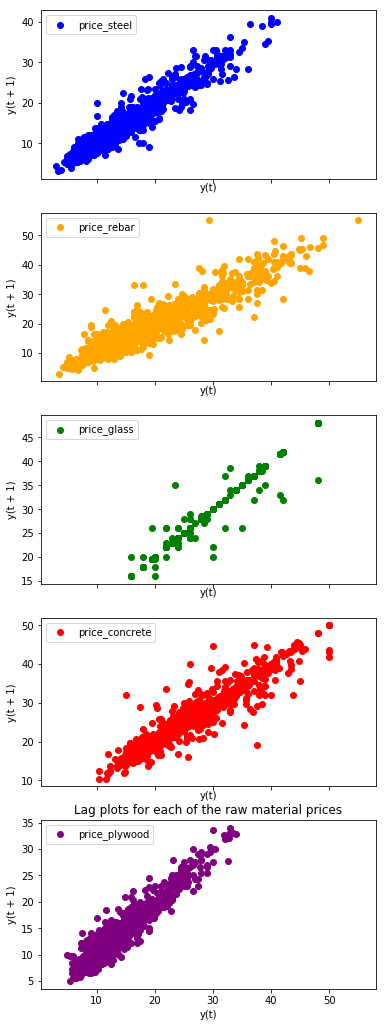

In [2]:
#Plot lag for all our prices, to see if there is structure to our timeseries or it's just random:
color_table= ['blue', 'orange', 'green', 'red', 'purple']
fig, axes = plt.subplots(5,1, sharex=True, figsize = (6,18))
for i, mat in enumerate(series.columns):
    pd.plotting.lag_plot(series[mat],label=mat, ax = axes[i],c=color_table[i])
    axes[i].legend(loc='upper left')
plt.title('Lag plots for each of the raw material prices')    


All of the material prices are strongly non-random. They are moderately autoregressive, with a positive autocorrelation (positive linear lag plots). 

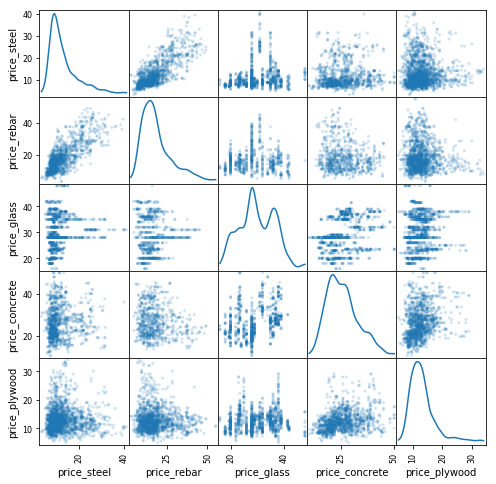

In [3]:
_=pd.plotting.scatter_matrix(series, alpha=0.2, figsize=(8, 8), diagonal='kde')

I need to find a way to impute the missing data, and go with monthly averages to make that easier. There might be better ways out there, but in the interest of time I'll go with monthly averages first (seems to be enough data to do that) and then imputing with the last available value.

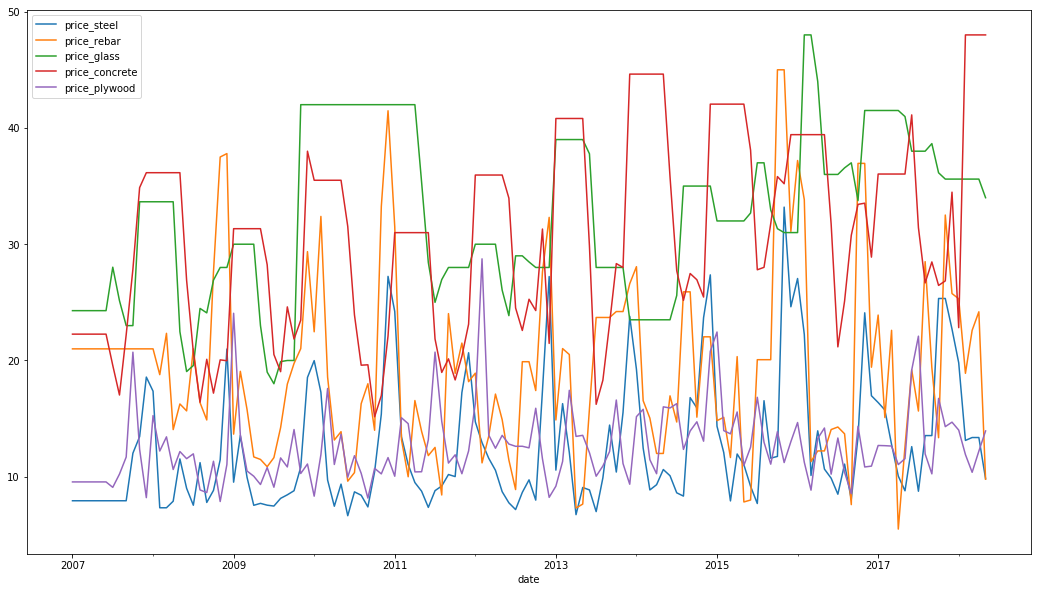

In [4]:
# The 'MS' string groups the data in buckets by start of the month
series_m = series.resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
series_m = series_m.fillna(series_m.bfill())

#print(series)
series_m.plot(figsize=(18,10))
plt.show()


Let's also try weekly averages and see what looks better:

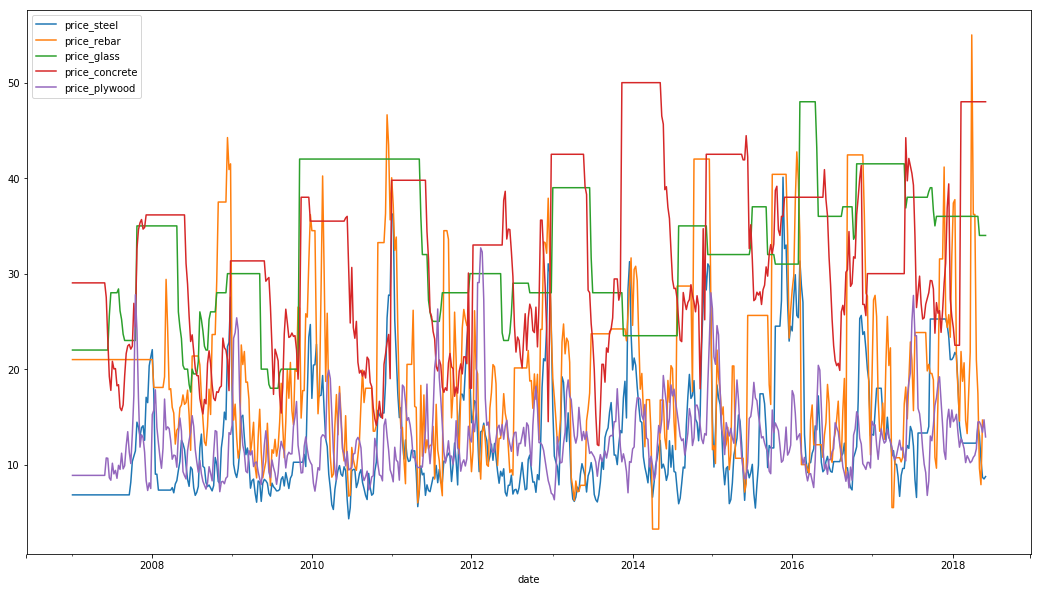

In [5]:
# The 'W' string groups the data by weeks
series_w = series.resample('W').mean()

# The term bfill means that we use the value before filling in missing values
series_w = series_w.fillna(series_w.bfill())

#print(series)
series_w.plot(figsize=(18,10))
plt.show()

Will continue analysis on the weekly averages one, as it preserves the fluctuations better.
Will also note that the price of steel cycles with a big annual peak (around the turn of the year), and a smaller peak around half way through the year (to keep in mind for choosing the gap for the model and also for recommending when to buy steel). The price of plywood has a similar frequency (although sometimes a bit offset from the price of steel). The price of rebar has similar fluctuations, but larger in amplitude (so definitely avoid buying in the peak price zone), while glass and concrete seem to go together to some extent, but are also the ones with most missing data (the imputation might be imperfect, treat with caution for now).

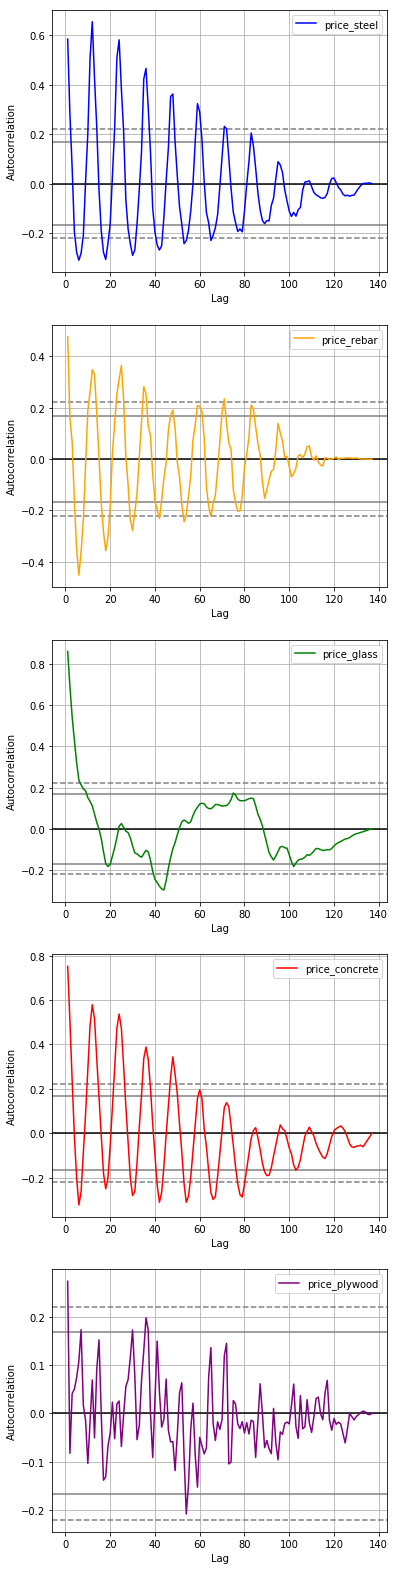

In [6]:
#Plot autocorrelations for all our prices, to see if there is structure to our timeseries or it's just random:
color_table= ['blue', 'orange', 'green', 'red', 'purple']
fig, axes = plt.subplots(5,1,figsize = (6,28))
for i, mat in enumerate(series_w.columns):
    pd.plotting.autocorrelation_plot(series_m[mat].dropna(),label=mat, ax = axes[i],c=color_table[i])
    axes[i].legend(loc='upper right')

# ARIMA for forecasting


In [7]:
import warnings
import itertools
import statsmodels.api as sm

I picked the weekly averages to have a better resolution than the monthly averages would give (tried both, the weekly one is more accurate). I have run SARIMAX to tune parameters for 6 month predictions (26 weeks), with the lag between 0 and 16, and found that 16 was the most accurate prediction (had the smallest associated AIC) for every material.

In [18]:
#pick parameters:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 16)
d = range(0, 1)
q = range(0, 1)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 26) for x in list(itertools.product(p, d, q))]


After getting the parameters tuned, I am applying them to each of the timeseries (for each material):

In [9]:
best_param = (16,0,0)
best_param_seasonal = (16,0,0,26)

###### ARIMA on price of steel

In [12]:
def run_sarimax(y, best_param, best_param_seasonal):
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order=best_param,
                                    seasonal_order=best_param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()

    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    
    pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = y['2007':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

    ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()

    plt.show()
    y_forecasted = pred.predicted_mean
    y_truth = y['2017-01-01':]

    # Compute the mean square error
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    ax = y['2007':].plot(label='observed', figsize=(20, 15))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    plt.legend()
    plt.show()
    # Extract the predicted and true values of our time series
    y_forecasted = pred_dynamic.predicted_mean
    y_truth = y['2017-01-01':]

    # Compute the mean square error
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    # Get forecast 50 steps ahead in future
    pred_uc = results.get_forecast(steps=26)

    # Get confidence intervals of forecasts
    pred_ci = pred_uc.conf_int()
    ax = y.plot(label='observed', figsize=(20, 15))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    plt.legend()
    plt.show()

/Users/oana/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0467      0.095     11.063      0.000       0.861       1.232
ar.L2          0.0785      0.195      0.403      0.687      -0.303       0.460
ar.L3         -0.4212      0.152     -2.780      0.005      -0.718      -0.124
ar.L4          0.1663      0.153      1.087      0.277      -0.134       0.466
ar.L5          0.3127      0.148      2.119      0.034       0.024       0.602
ar.L6         -0.4402      0.159     -2.773      0.006      -0.751      -0.129
ar.L7          0.0256      0.167      0.153      0.879      -0.302       0.353
ar.L8          0.3511      0.164      2.136      0.033       0.029       0.673
ar.L9         -0.2650      0.151     -1.751      0.080      -0.562       0.032
ar.L10        -0.0011      0.145     -0.008      0.994      -0.285       0.283
ar.L11         0.4297      0.136      3.164      0.0

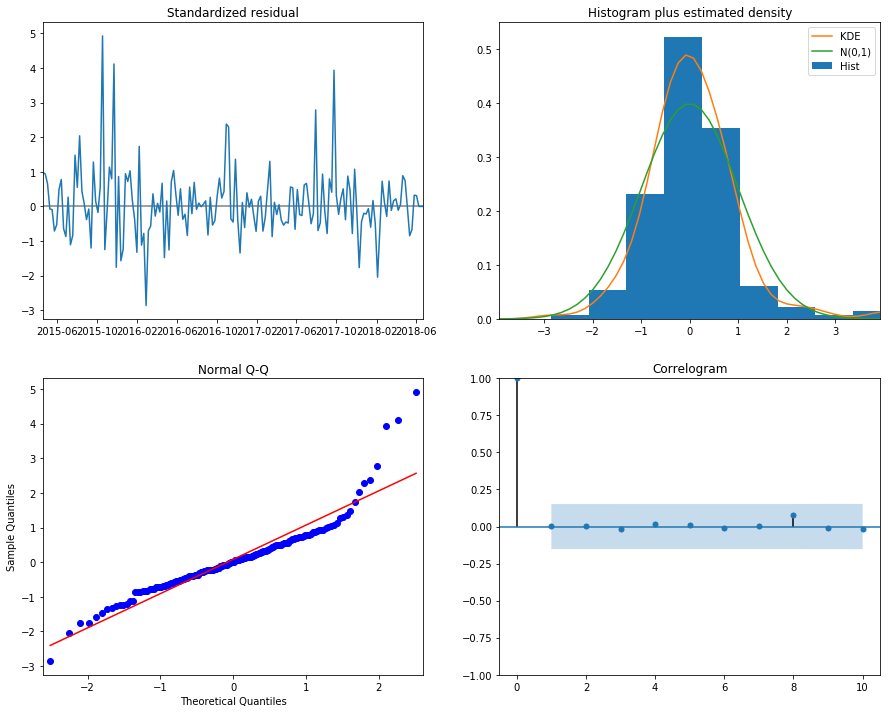

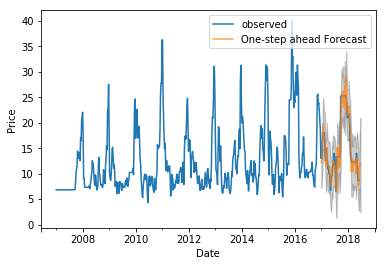

The Mean Squared Error of our forecasts is 4.26


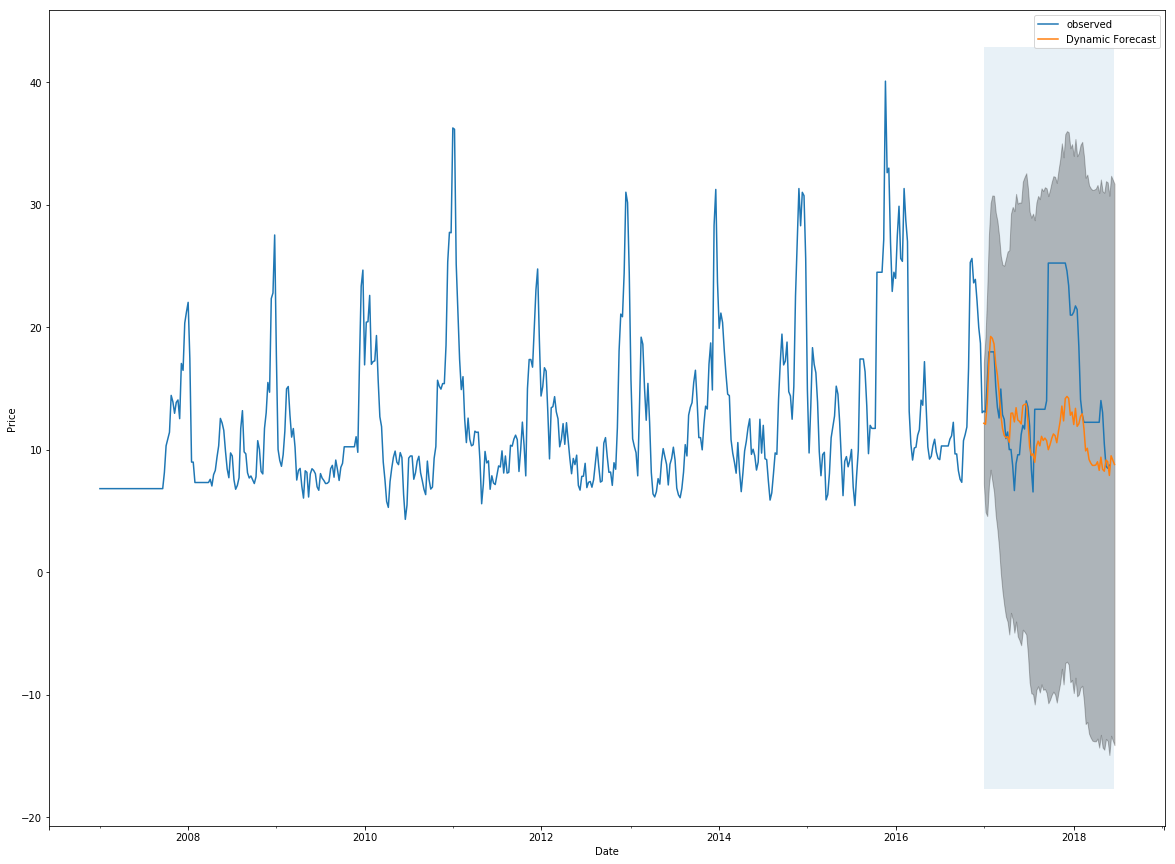

The Mean Squared Error of our forecasts is 40.17


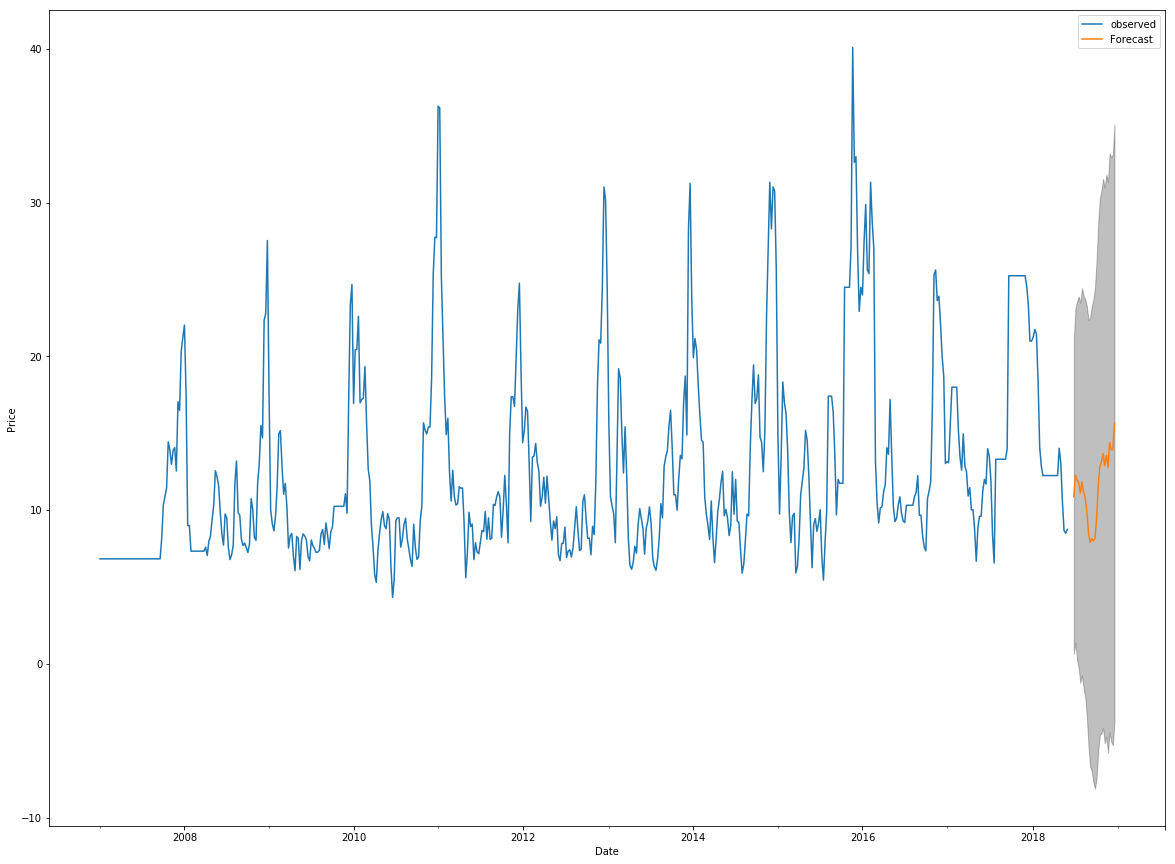

In [13]:
y = series_w['price_steel']
run_sarimax(y, best_param, best_param_seasonal)

###### ARIMA on price of rebar

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9120      0.112      8.118      0.000       0.692       1.132
ar.L2         -0.1038      0.170     -0.609      0.543      -0.438       0.230
ar.L3         -0.0932      0.161     -0.578      0.563      -0.409       0.223
ar.L4         -0.1011      0.140     -0.721      0.471      -0.376       0.174
ar.L5          0.0444      0.138      0.321      0.748      -0.227       0.316
ar.L6         -0.0064      0.158     -0.041      0.967      -0.316       0.303
ar.L7          0.0917      0.185      0.495      0.620      -0.271       0.455
ar.L8         -0.1392      0.173     -0.805      0.421      -0.478       0.200
ar.L9          0.1563      0.180      0.866      0.387      -0.197       0.510
ar.L10        -0.0457      0.207     -0.221      0.825      -0.451       0.360
ar.L11        -0.1534      0.166     -0.924      0.3

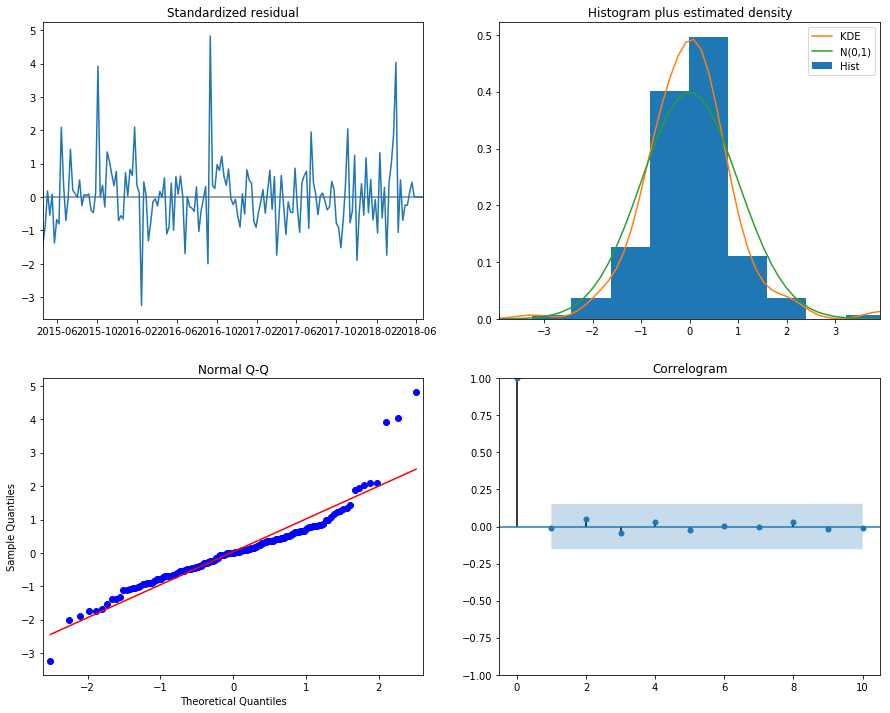

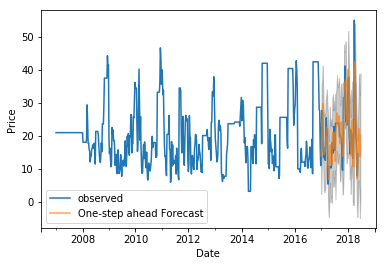

The Mean Squared Error of our forecasts is 31.32


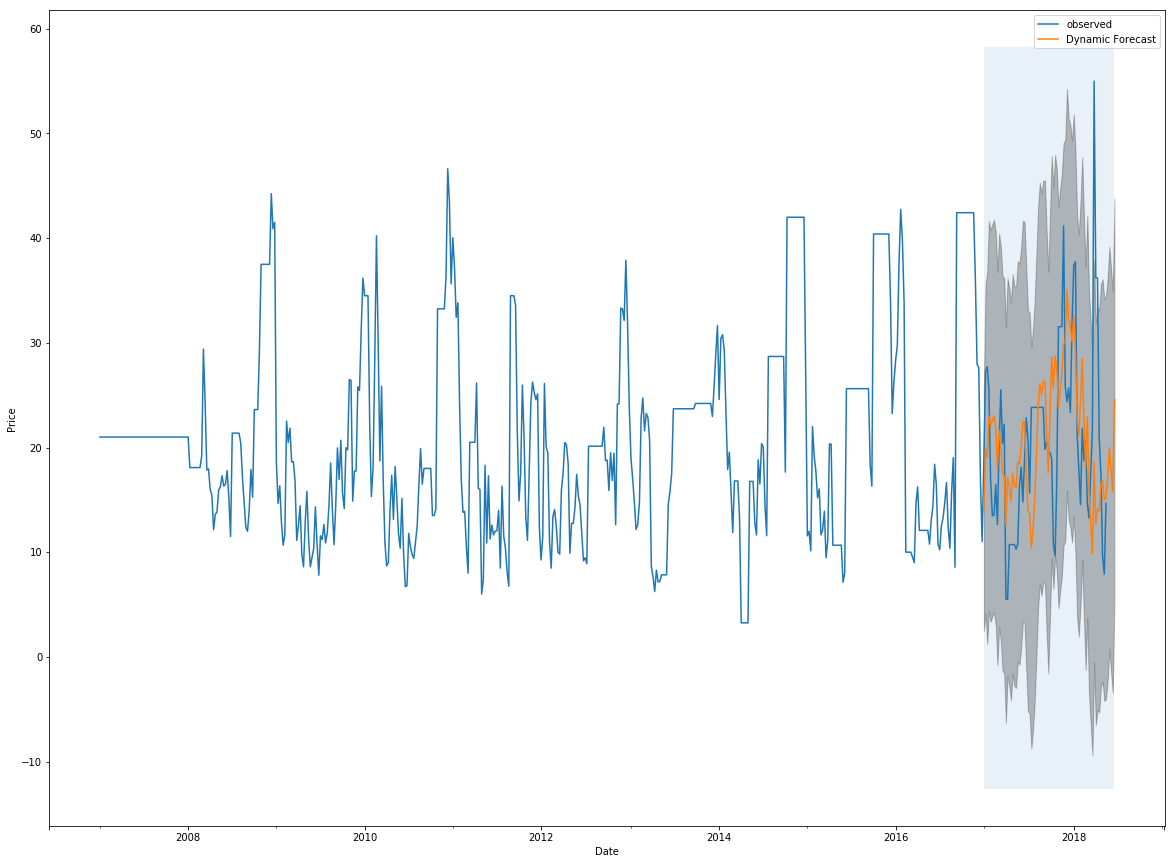

The Mean Squared Error of our forecasts is 80.08


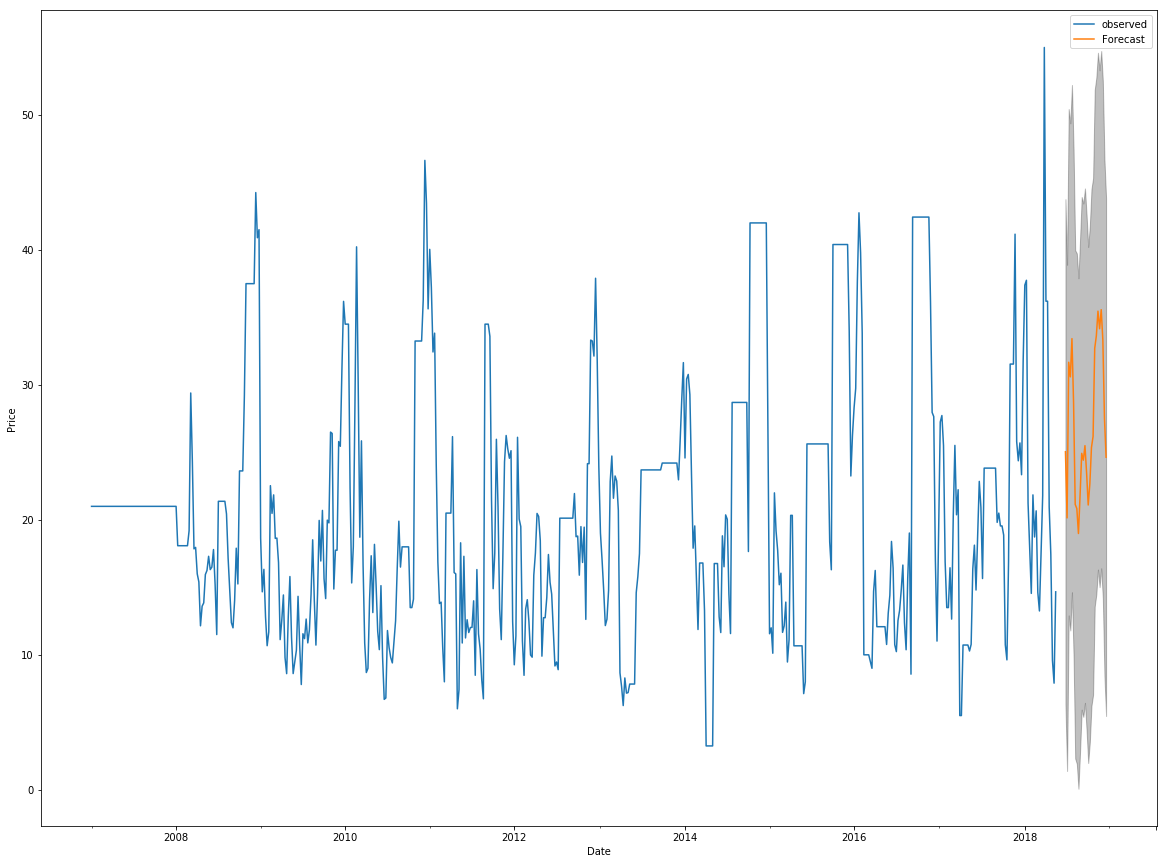

In [14]:
y = series_w['price_rebar']
run_sarimax(y, best_param, best_param_seasonal)

###### ARIMA on price of glass

/Users/oana/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8363      0.206      4.058      0.000       0.432       1.240
ar.L2         -0.0648      0.241     -0.269      0.788      -0.538       0.408
ar.L3          0.0269      0.202      0.133      0.894      -0.370       0.423
ar.L4          0.0120      0.220      0.054      0.957      -0.420       0.444
ar.L5          0.0091      0.192      0.047      0.962      -0.367       0.385
ar.L6          0.0561      0.216      0.259      0.795      -0.368       0.480
ar.L7         -0.0175      0.249     -0.070      0.944      -0.506       0.471
ar.L8         -0.0032      0.271     -0.012      0.991      -0.535       0.528
ar.L9          0.0476      0.262      0.182      0.856      -0.467       0.562
ar.L10        -0.0754      0.216     -0.349      0.727      -0.498       0.348
ar.L11        -0.1271      0.170     -0.748      0.4

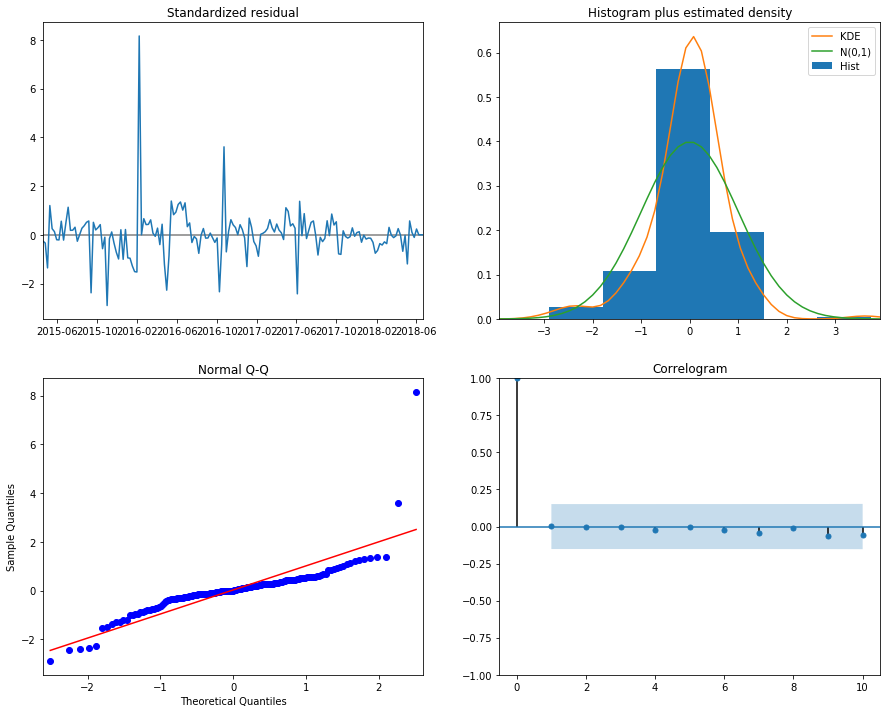

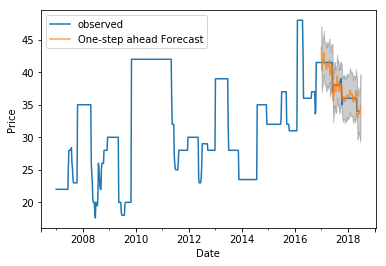

The Mean Squared Error of our forecasts is 0.93


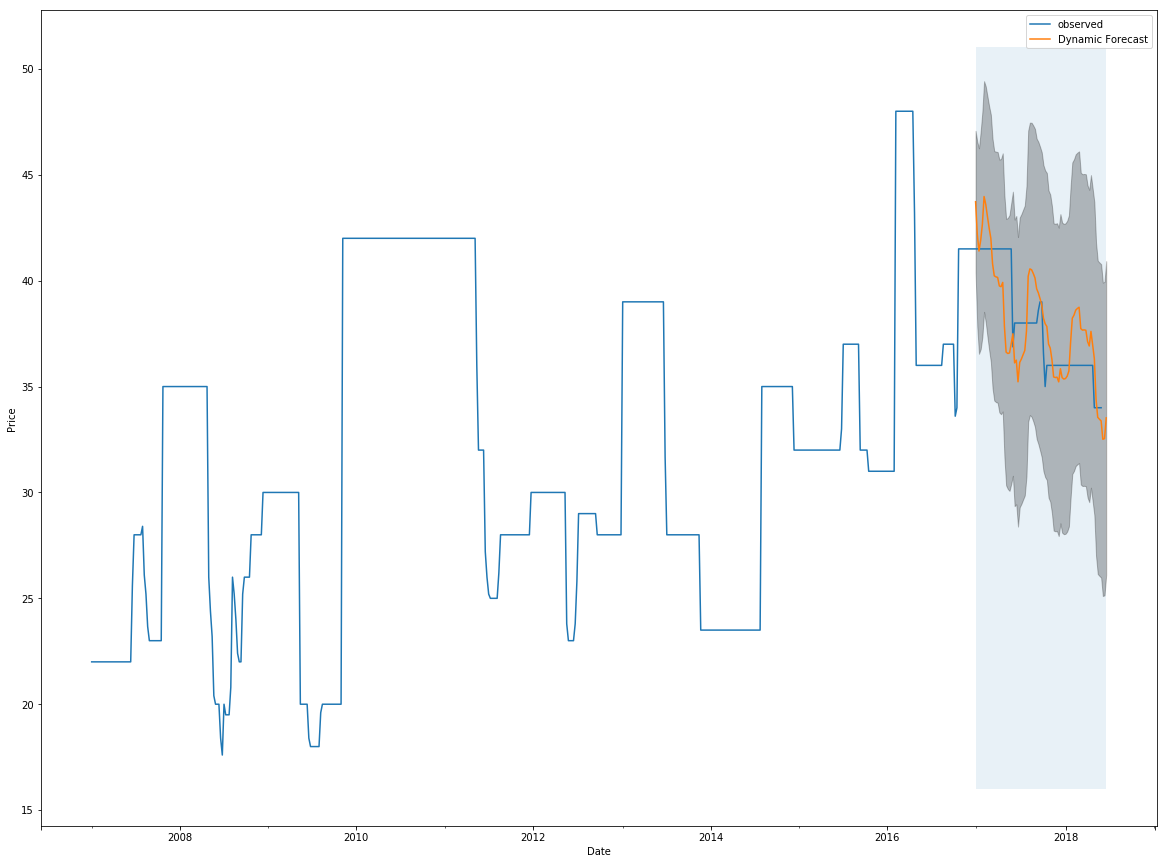

The Mean Squared Error of our forecasts is 3.65


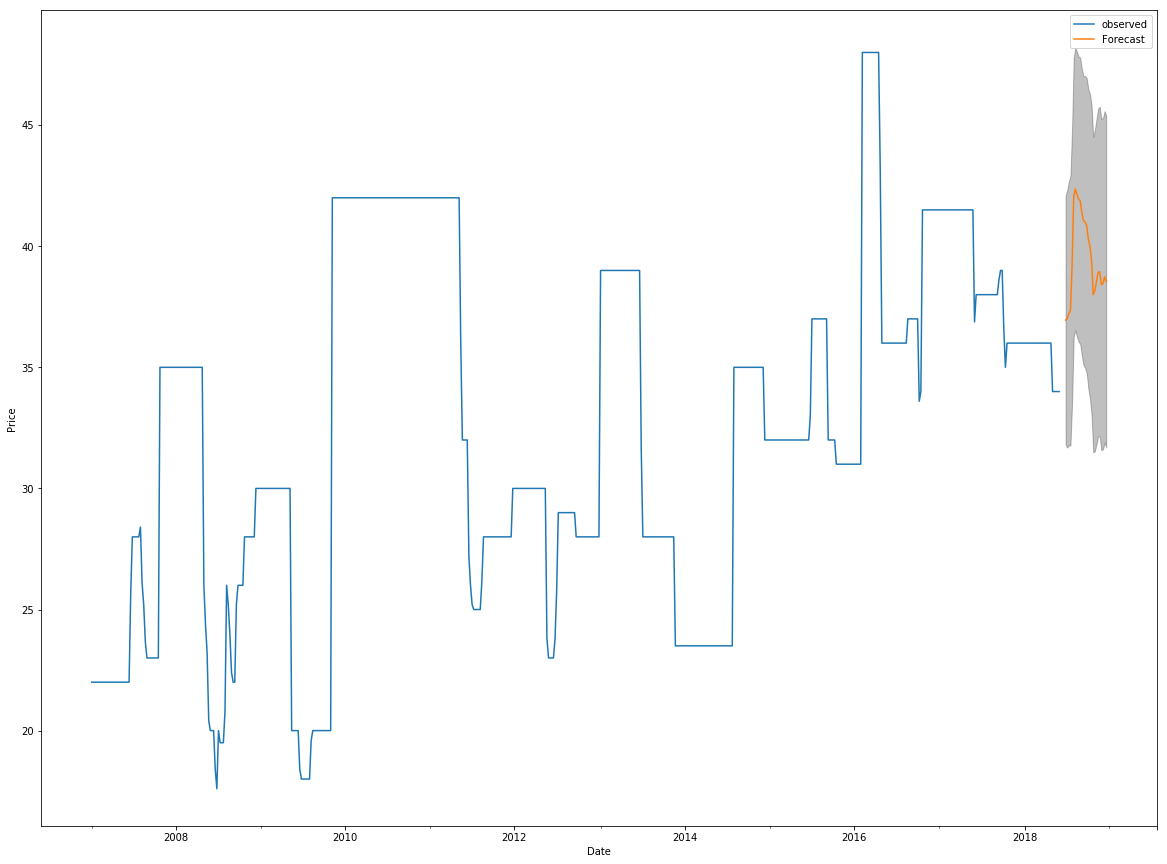

In [15]:
y = series_w['price_glass']
run_sarimax(y, best_param, best_param_seasonal)

###### ARIMA on price of concrete

/Users/oana/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9367      0.188      4.991      0.000       0.569       1.304
ar.L2         -0.0540      0.221     -0.244      0.807      -0.488       0.380
ar.L3         -0.0289      0.170     -0.170      0.865      -0.362       0.304
ar.L4          0.0081      0.154      0.053      0.958      -0.293       0.309
ar.L5          0.0717      0.168      0.426      0.670      -0.258       0.402
ar.L6         -0.1338      0.182     -0.735      0.462      -0.490       0.223
ar.L7         -0.0986      0.143     -0.687      0.492      -0.380       0.183
ar.L8          0.2720      0.152      1.794      0.073      -0.025       0.569
ar.L9         -0.0728      0.206     -0.354      0.723      -0.476       0.330
ar.L10        -0.0722      0.204     -0.355      0.723      -0.471       0.327
ar.L11         0.0485      0.174      0.278      0.7

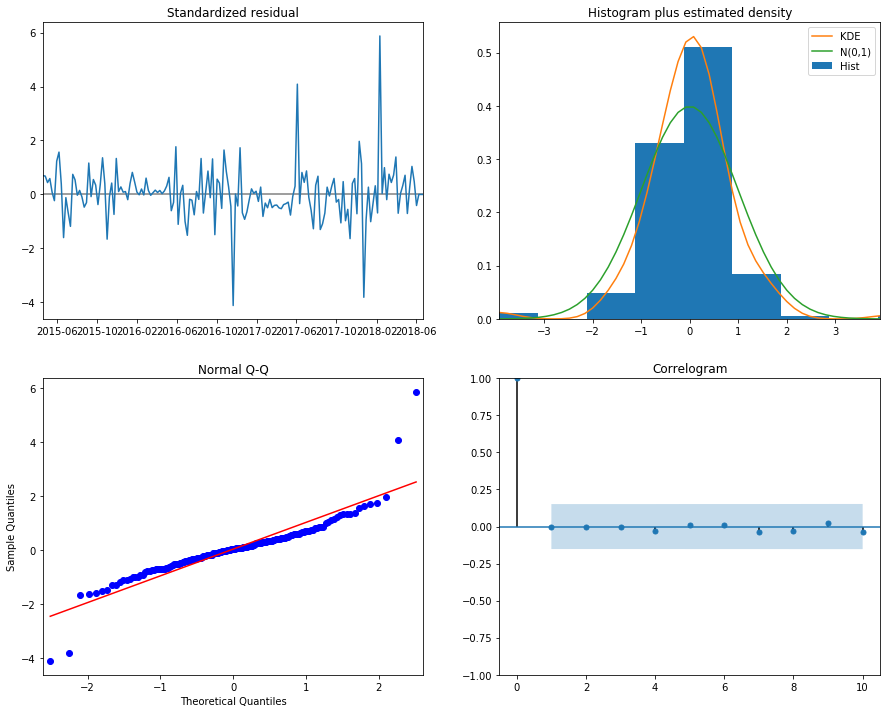

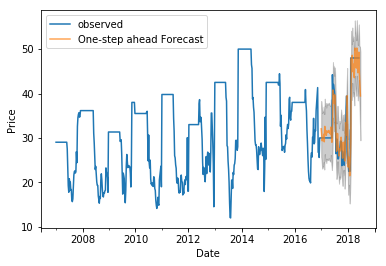

The Mean Squared Error of our forecasts is 13.45


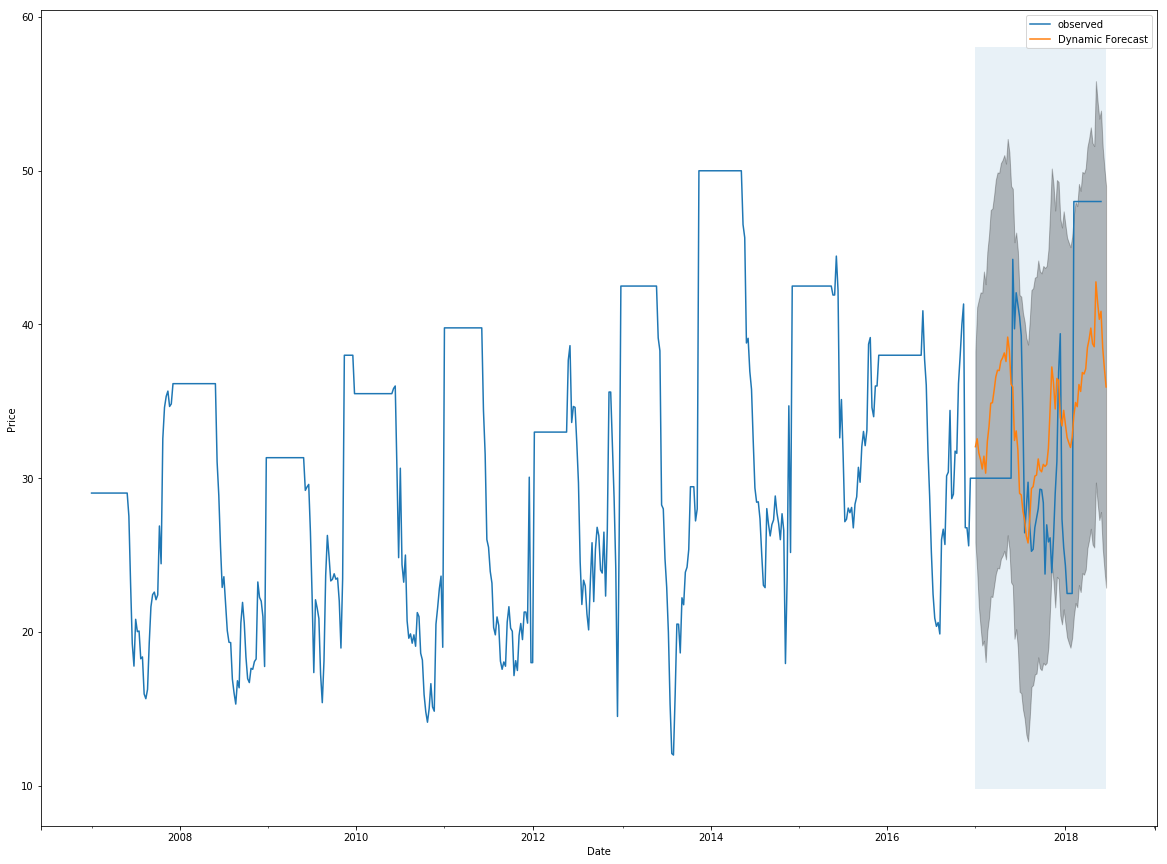

The Mean Squared Error of our forecasts is 57.12


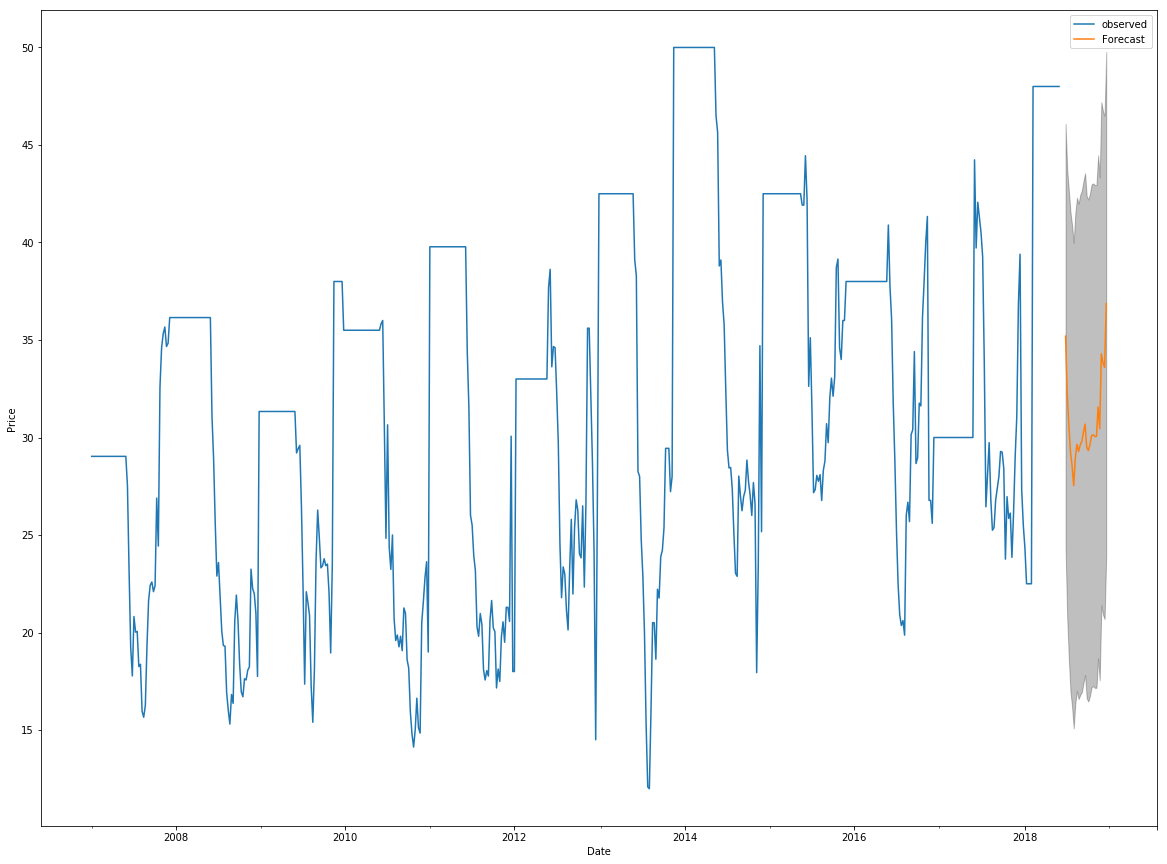

In [16]:
y = series_w['price_concrete']
run_sarimax(y, best_param, best_param_seasonal)

###### ARIMA on price of plywood

/Users/oana/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8456      0.092      9.167      0.000       0.665       1.026
ar.L2         -0.0639      0.159     -0.402      0.687      -0.375       0.247
ar.L3         -0.2225      0.159     -1.399      0.162      -0.534       0.089
ar.L4          0.2587      0.108      2.396      0.017       0.047       0.470
ar.L5         -0.0260      0.140     -0.185      0.853      -0.301       0.249
ar.L6         -0.0674      0.124     -0.543      0.587      -0.311       0.176
ar.L7         -0.2455      0.122     -2.019      0.043      -0.484      -0.007
ar.L8          0.1727      0.138      1.248      0.212      -0.098       0.444
ar.L9          0.1641      0.126      1.301      0.193      -0.083       0.411
ar.L10        -0.3368      0.136     -2.469      0.014      -0.604      -0.069
ar.L11         0.2344      0.135      1.735      0.0

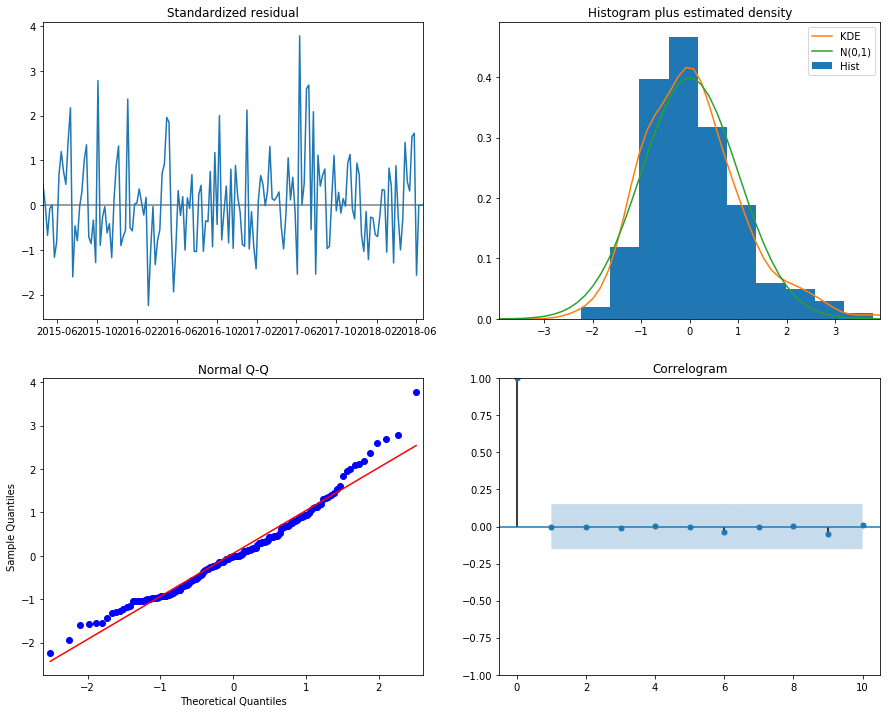

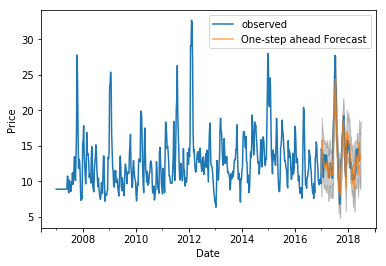

The Mean Squared Error of our forecasts is 2.9


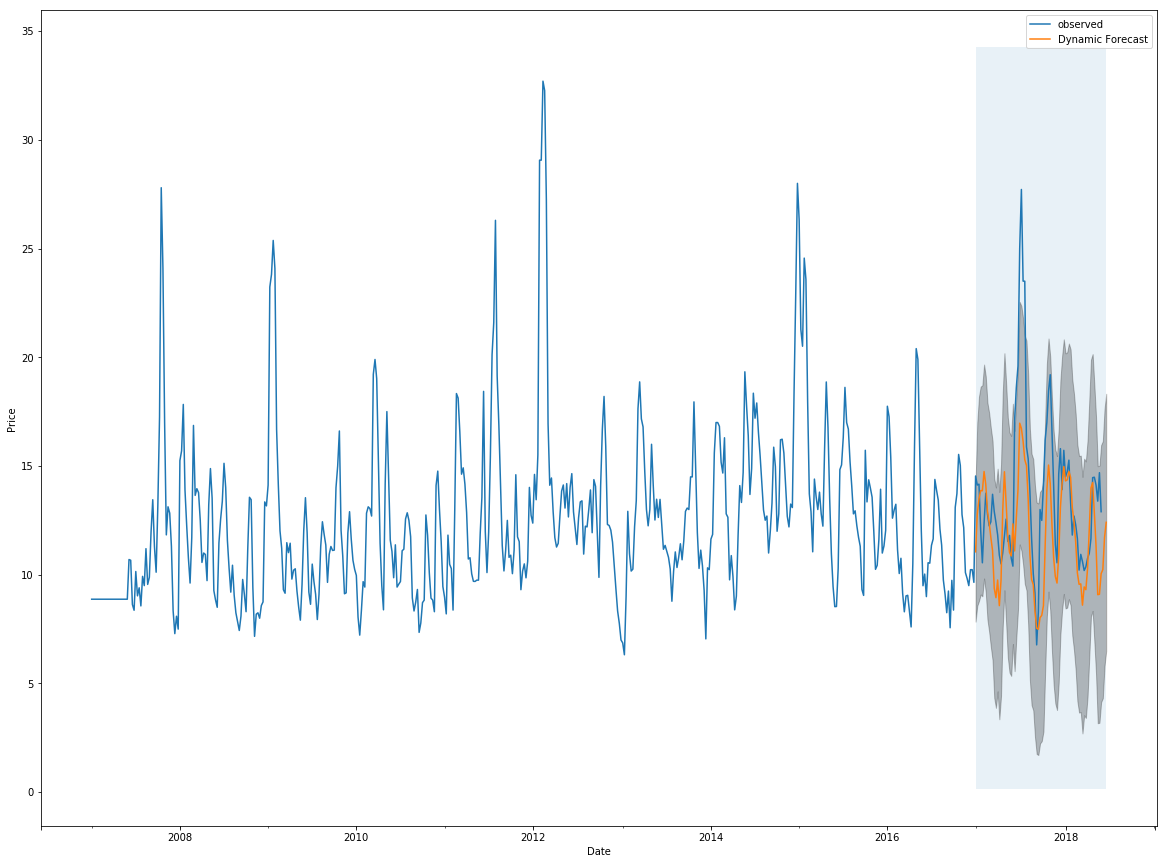

The Mean Squared Error of our forecasts is 10.84


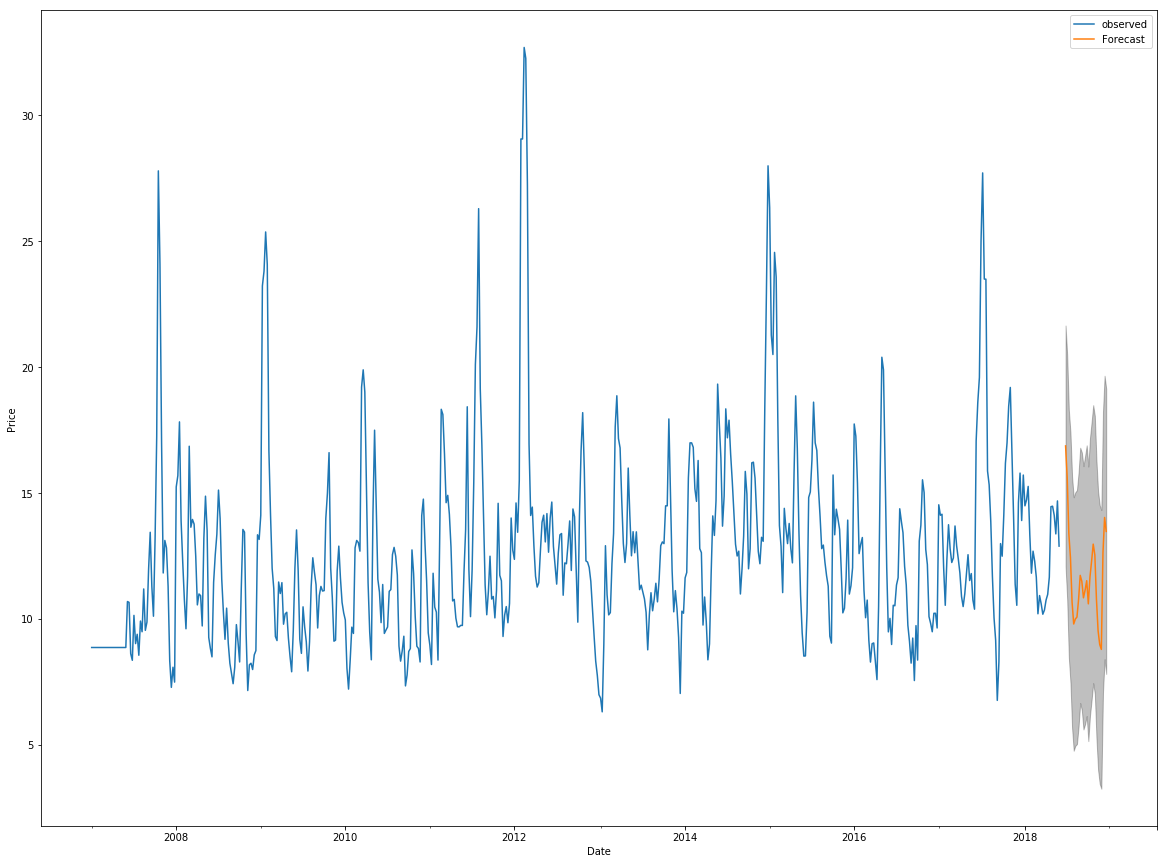

In [17]:
y = series_w['price_plywood']
run_sarimax(y, best_param, best_param_seasonal)